# Exploratory Data Analysis

## MQTTSET

In [1]:
import kagglehub
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Load Dataset

In [2]:
mqtt_path = kagglehub.dataset_download("cnrieiit/mqttset")
mqtt_df = pl.read_csv(f"{mqtt_path}/Data/FINAL_CSV/train70.csv", infer_schema_length=10_000)

In [3]:
mqtt_df.head()

tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.uname,mqtt.conflag.willflag,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,target
str,f64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""0x00000018""",0.000141,13,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""32""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate"""
"""0x00000018""",0.998962,13,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""30""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate"""
"""0x00000010""",0.000007,0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate"""
"""0x00000018""",0.000141,13,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""31""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate"""
"""0x00000010""",0.000009,0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate"""


In [4]:
mqtt_df.describe()

statistic,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.uname,mqtt.conflag.willflag,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,target
str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""8456823""",8.456823e6,8.456823e6,"""8456823""",8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,"""8456823""",8.456823e6,"""8456823""",8.456823e6,8.456823e6,"""8456823""",8.456823e6,8.456823e6,8.456823e6,"""8456823""",8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,"""8456823"""
"""null_count""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,0.501038,11.678892,null,0.0,0.0,0.000598,0.000263,0.000119,0.0,0.0,0.0,0.000119,0.0,null,0.001436,null,4.808265,7.205809,null,31.855679,2.051298,0.001053,null,0.004465,0.00001,0.0,0.0,0.001053,0.0,0.0,0.0,0.0,null
"""std""",null,3.802169,158.644072,null,0.0,0.0,0.054666,0.016226,0.01089,0.0,0.0,0.0,0.010912,0.0,null,0.037864,null,560.660072,12.107938,null,421.816083,1.98635,0.064902,null,0.066668,0.003207,0.0,0.0,0.064902,0.0,0.0,0.0,0.0,null
"""min""","""0x00000002""",-0.000002,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""bruteforce"""
"""25%""",null,0.000004,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,null,0.0,0.0,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
"""50%""",null,0.000073,12.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,null,0.0,10.0,null,0.0,3.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
"""75%""",null,0.998826,13.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,null,0.0,11.0,null,0.0,3.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
"""max""","""0x00000019""",60.001888,32768.0,"""0x00000000""",0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"""0x000000c2""",1.0,"""0x000000e0""",65535.0,692.0,"""746573747465737474657374""",9994.0,14.0,4.0,"""MQTT""",1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,"""slowite"""


### Analyse Columns

Here, we wanna see for every column, what the data looks like? What is the data type? (float?, string?) Are any columns redundant? Meaning they have the same data for all rows? How many unique items do we have for each column?

In [5]:
def data_structure_analysis(df: pl.DataFrame, features: list | None = None):
    """
    For a given Polars DataFrame, analyzes variable types, missing values, and distribution.

    Parameters:
    ----------
    df: pl.DataFrame
    features: list of column names to analyze. If empty, all columns will be considered.

    Returns:
    -------
    pl.DataFrame with structure analysis and recommendations for each feature.
    """

    # Use all columns if features not specified
    features = features or df.columns

    # Helper function to get value densities
    def value_densities(dataframe: pl.DataFrame, col):
        vc = dataframe[col].value_counts(sort=True)
        vc = vc.with_columns((pl.col("count") / pl.col("count").sum()).alias("density"))
        vc = vc.with_columns((pl.col("density") * 100).round(3).alias("density"))
        return vc["density"].to_list()

    # Collect column-wise stats
    result_data = []

    for col in features:
        series = df[col]
        dtype = series.dtype

        total = df.height
        missing = df.select(pl.col(col).is_null().sum())[0, 0]
        observed = total - missing
        missing_rate = round((missing / total) * 100, 2) if total > 0 else 0.0

        nunique = df.select(pl.col(col).n_unique())[0, 0]

        # Distribution densities
        densities = value_densities(df, col)
        first_density = densities[0]
        second_density = densities[1] if len(densities) > 1 else 0.0
        diff_density = round(first_density - second_density, 3)

        # Determine feature type
        if nunique <= 1:
            feature_type = "Superfluous"
        elif nunique == 2:
            feature_type = "Flag"
        elif 2 < nunique <= 10:
            feature_type = "Categorical"
        else:
            feature_type = "Categorical - High Cardinality"

        result_data.append(
            {
                "Feature": col,
                "Observations": observed,
                "Missing": missing,
                "Missing rate (%)": missing_rate,
                "1st value density (%)": first_density,
                "1st to 2nd value density difference (%)": diff_density,
                "Variable type": str(dtype),
                "Unique values": nunique,
                "Feature type": feature_type,
            }
        )

    # Create Polars DataFrame and sort it
    result_df = pl.DataFrame(result_data)
    result_df = result_df.sort(["Feature type", "Unique values"])

    return result_df

In [6]:
mqtt_columns_df = data_structure_analysis(mqtt_df)

In [7]:
mqtt_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""mqtt.conflags""",8456823,0,0.0,99.974,99.96,"""String""",4,"""Categorical"""
"""target""",8456823,0,0.0,98.63,97.552,"""String""",6,"""Categorical"""
"""mqtt.kalive""",8456823,0,0.0,99.974,99.956,"""Float64""",7,"""Categorical"""
"""tcp.flags""",8456823,0,0.0,62.823,25.76,"""String""",8,"""Categorical"""
"""mqtt.msgtype""",8456823,0,0.0,60.953,23.957,"""Float64""",11,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""mqtt.willmsg""",8456823,0,0.0,100.0,100.0,"""Float64""",1,"""Superfluous"""
"""mqtt.willmsg_len""",8456823,0,0.0,100.0,100.0,"""Float64""",1,"""Superfluous"""
"""mqtt.willtopic""",8456823,0,0.0,100.0,100.0,"""Float64""",1,"""Superfluous"""


#### Remove rows that are superfluous (have only one unique type). That won't help us.

In [8]:
superfluous_df = mqtt_columns_df.filter(pl.col("Feature type") == "Superfluous")
print("Number of Superfluous columns:", len(superfluous_df))
superfluous_df["Feature"]

Number of Superfluous columns: 12


Feature
str
"""mqtt.conflag.qos"""
"""mqtt.conack.flags.sp"""
"""mqtt.conflag.willflag"""
"""mqtt.conflag.retain"""
"""mqtt.sub.qos"""
…
"""mqtt.willmsg"""
"""mqtt.willmsg_len"""
"""mqtt.willtopic"""


In [9]:
superfluous_columns = mqtt_columns_df.filter(pl.col("Feature type") == "Superfluous")[
    "Feature"
].to_list()
mqtt_df = mqtt_df.select(pl.exclude(superfluous_columns))
print("Number of columns:", len(mqtt_df.columns))

Number of columns: 22


#### Inspects Possible Flags Columns

In [10]:
mqtt_df.head()

tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.ver,target
str,f64,i64,str,f64,f64,f64,f64,str,f64,str,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str
"""0x00000018""",0.000141,13,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""32""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,"""legitimate"""
"""0x00000018""",0.998962,13,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""30""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,"""legitimate"""
"""0x00000010""",0.000007,0,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""legitimate"""
"""0x00000018""",0.000141,13,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0x00000030""",0.0,11.0,"""31""",0.0,3.0,0.0,"""0""",0.0,0.0,0.0,"""legitimate"""
"""0x00000010""",0.000009,0,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""legitimate"""


In [11]:
flags_df = mqtt_columns_df.filter(
    pl.col("Feature").str.ends_with("flags") | (pl.col("Feature type") == "Flag")
).sort("Unique values", descending=True)
print("Number of Flag columns:", len(flags_df))
flags_df[["Feature", "Variable type", "Unique values", "Feature type"]]

Number of Flag columns: 14


Feature,Variable type,Unique values,Feature type
str,str,i64,str
"""mqtt.hdrflags""","""String""",14,"""Categorical - High Cardinality"""
"""tcp.flags""","""String""",8,"""Categorical"""
"""mqtt.conflags""","""String""",4,"""Categorical"""
"""mqtt.conflag.passwd""","""Float64""",2,"""Flag"""
"""mqtt.proto_len""","""Float64""",2,"""Flag"""
…,…,…,…
"""mqtt.dupflag""","""Float64""",2,"""Flag"""
"""mqtt.conack.flags""","""String""",2,"""Flag"""
"""mqtt.conflag.cleansess""","""Float64""",2,"""Flag"""


`mqtt.hdrflags`, `tcg.flags`, `mqtt.conflags`, `mqtt.conack.flags`, and `mqtt.protoname` are strings, the rest as Float64. Let's take a look at these columns  with string variable type. I suspect they are hex string and can be converted to int.

In [12]:
string_flag_cols = flags_df.filter(pl.col("Variable type") == "String")["Feature"]
mqtt_df[string_flag_cols].head()

mqtt.hdrflags,tcp.flags,mqtt.conflags,mqtt.conack.flags,mqtt.protoname
str,str,str,str,str
"""0x00000030""","""0x00000018""","""0""","""0""","""0"""
"""0x00000030""","""0x00000018""","""0""","""0""","""0"""
"""0""","""0x00000010""","""0""","""0""","""0"""
"""0x00000030""","""0x00000018""","""0""","""0""","""0"""
"""0""","""0x00000010""","""0""","""0""","""0"""


In [13]:
for col in string_flag_cols:
    print(f"Value counts for column '{col}':")
    print(mqtt_df[col].value_counts().sort(by=col))

Value counts for column 'mqtt.hdrflags':
shape: (14, 2)
┌───────────────┬─────────┐
│ mqtt.hdrflags ┆ count   │
│ ---           ┆ ---     │
│ str           ┆ u32     │
╞═══════════════╪═════════╡
│ 0             ┆ 3128685 │
│ 0x00000010    ┆ 2227    │
│ 0x00000020    ┆ 2226    │
│ 0x00000030    ┆ 5116816 │
│ 0x00000031    ┆ 87      │
│ …             ┆ …       │
│ 0x00000082    ┆ 65      │
│ 0x00000090    ┆ 65      │
│ 0x000000c0    ┆ 70592   │
│ 0x000000d0    ┆ 70592   │
│ 0x000000e0    ┆ 3       │
└───────────────┴─────────┘
Value counts for column 'tcp.flags':
shape: (8, 2)
┌────────────┬─────────┐
│ tcp.flags  ┆ count   │
│ ---        ┆ ---     │
│ str        ┆ u32     │
╞════════════╪═════════╡
│ 0x00000002 ┆ 2574    │
│ 0x00000004 ┆ 1087    │
│ 0x00000010 ┆ 3134317 │
│ 0x00000011 ┆ 2932    │
│ 0x00000012 ┆ 2574    │
│ 0x00000014 ┆ 28      │
│ 0x00000018 ┆ 5312797 │
│ 0x00000019 ┆ 514     │
└────────────┴─────────┘
Value counts for column 'mqtt.conflags':
shape: (4, 2)
┌───────────

If you peek, `mqtt.protoname` has two values (`0`, and `MQTT`) and is not hex, while the others are hexstrings.

In [14]:
mqtt_df = mqtt_df.with_columns(
    (
        (
            pl.col(col).map_elements(lambda x: int(x, 16), return_dtype=pl.Int64).alias(col)
            if col != "mqtt.protoname"
            else (pl.col(col) == "MQTT").alias("is_mqtt_proto")
        )
        for col in string_flag_cols
    )
)
# We remove the old "mqtt.protoname" column because we now using "is_mqtt_proto"
mqtt_df = mqtt_df.select(pl.exclude(["mqtt.protoname"]))
mqtt_df.head()

tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.qos,mqtt.retain,mqtt.ver,target,is_mqtt_proto
i64,f64,i64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,bool
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""32""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false
24,0.998962,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""30""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false
16,0.000007,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""31""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false
16,0.000009,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false


In [15]:
mqtt_df.describe()

statistic,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.qos,mqtt.retain,mqtt.ver,target,is_mqtt_proto
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64
"""count""",8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,"""8456823""",8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,8.456823e6,"""8456823""",8.456823e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""",21.021521,0.501038,11.678892,0.0,0.000598,0.000263,0.000119,0.000119,0.023359,0.001436,32.841212,4.808265,7.205809,null,31.855679,2.051298,0.001053,0.004465,0.00001,0.001053,null,0.000263
"""std""",3.882719,3.802169,158.644072,0.0,0.054666,0.016226,0.01089,0.010912,2.114651,0.037864,31.793848,560.660072,12.107938,null,421.816083,1.98635,0.064902,0.066668,0.003207,0.064902,null,null
"""min""",2.0,-0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""bruteforce""",0.0
"""25%""",16.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,null,null
"""50%""",24.0,0.000073,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,10.0,null,0.0,3.0,0.0,0.0,0.0,0.0,null,null
"""75%""",24.0,0.998826,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,11.0,null,0.0,3.0,0.0,0.0,0.0,0.0,null,null
"""max""",25.0,60.001888,32768.0,0.0,5.0,1.0,1.0,1.0,194.0,1.0,224.0,65535.0,692.0,"""746573747465737474657374""",9994.0,14.0,4.0,1.0,1.0,4.0,"""slowite""",1.0


So let's see the columns we haven't taken a look a yet.

In [16]:
mqtt_columns_df.filter(~pl.col("Feature").is_in(string_flag_cols.to_list() + superfluous_columns))

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""target""",8456823,0,0.0,98.63,97.552,"""String""",6,"""Categorical"""
"""mqtt.kalive""",8456823,0,0.0,99.974,99.956,"""Float64""",7,"""Categorical"""
"""mqtt.msgtype""",8456823,0,0.0,60.953,23.957,"""Float64""",11,"""Categorical - High Cardinality"""
"""mqtt.len""",8456823,0,0.0,38.665,0.811,"""Float64""",92,"""Categorical - High Cardinality"""
"""tcp.len""",8456823,0,0.0,37.858,0.874,"""Int64""",723,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""mqtt.conflag.uname""",8456823,0,0.0,99.988,99.976,"""Float64""",2,"""Flag"""
"""mqtt.qos""",8456823,0,0.0,99.554,99.108,"""Float64""",2,"""Flag"""
"""mqtt.dupflag""",8456823,0,0.0,99.856,99.712,"""Float64""",2,"""Flag"""


If you look closely we got two more columns that are strings (`target`, and `mqtt.msg`)

#### Convert `target` column

The `target` describes the nature of a sample (whether it's legitimate or created by some maliciuous technique).

In [17]:
mqtt_df["target"].unique()

target
str
"""dos"""
"""legitimate"""
"""flood"""
"""bruteforce"""
"""malformed"""
"""slowite"""


We gonna map `legitimate` to `0` meaning no anomaly, and other values to a `1`, meaning there's an anomaly

In [18]:
coding_bin = {
    "legitimate": 0,
    "dos": 1,
    "malformed": 1,
    "bruteforce": 1,
    "slowite": 1,
    "flood": 1,
}
mqtt_df = mqtt_df.with_columns(
    pl.col("target").replace_strict(coding_bin, return_dtype=pl.Int64).alias("label")
)
mqtt_df.head()

tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.qos,mqtt.retain,mqtt.ver,target,is_mqtt_proto,label
i64,f64,i64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,bool,i64
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""32""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
24,0.998962,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""30""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
16,0.000007,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""31""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
16,0.000009,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0


#### Take a look at the last string column, `mqtt.msg`

How many unique values we got?

In [19]:
unique_mqtt_msgs = mqtt_df["mqtt.msg"].unique()
print("Number of unique mqtt.msg:", len(unique_mqtt_msgs))
unique_mqtt_msgs.head(n=20)

Number of unique mqtt.msg: 36067


mqtt.msg
str
"""613230346262333330343263453866…"
"""616239313643314263634331433041…"
"""456435613663636146423934443736…"
"""634644366661613838413861303232…"
"""413133383236373137454338443037…"
…
"""323362626346423544364261464542…"
"""383536303337394532453943343645…"
"""434632344138463864466544644346…"


How long are the `mqtt.msg` entries?

In [20]:
mqtt_df.with_columns(pl.col("mqtt.msg").str.len_chars().alias("mqtt.msg.length"))[
    "mqtt.msg.length"
].describe()

statistic,value
str,f64
"""count""",8.456823e6
"""null_count""",0.0
"""mean""",2.856972
"""std""",13.219478
"""min""",1.0
"""25%""",1.0
"""50%""",2.0
"""75%""",2.0
"""max""",240.0


Do the string contain only numbers? or have valid hex characters or are arbritrary?

In [35]:
# let's try converting to float, to see if it works successfully?

def convert_msg_to_num(msg: str):
    try:
        return float(msg)
    except ValueError:
        return int(msg, 16)
try:
    mqtt_df = mqtt_df.with_columns(
        pl.col("mqtt.msg").map_elements(convert_msg_to_num, return_dtype=pl.Float64).alias("mqtt.msg.float")
    )["mqtt.msg.float"].describe()
except pl.exceptions.ComputeError as e:
    print(e)

In [ ]:
mqtt_df[["mqtt.msg", "mqtt.msg.float", "label"]]

Alright, that doesn't seem to work. We might just use it as string type. Although, still wondering if the content affects the value of `target`

Let's take a look, at the other columns not analyzed yet

In [22]:
mqtt_columns_df.filter(
    ~pl.col("Feature").is_in(
        string_flag_cols.to_list() + superfluous_columns + ["target", "mqtt.msg"]
    )
)

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""mqtt.kalive""",8456823,0,0.0,99.974,99.956,"""Float64""",7,"""Categorical"""
"""mqtt.msgtype""",8456823,0,0.0,60.953,23.957,"""Float64""",11,"""Categorical - High Cardinality"""
"""mqtt.len""",8456823,0,0.0,38.665,0.811,"""Float64""",92,"""Categorical - High Cardinality"""
"""tcp.len""",8456823,0,0.0,37.858,0.874,"""Int64""",723,"""Categorical - High Cardinality"""
"""mqtt.msgid""",8456823,0,0.0,99.224,99.223,"""Float64""",9813,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""mqtt.conflag.uname""",8456823,0,0.0,99.988,99.976,"""Float64""",2,"""Flag"""
"""mqtt.qos""",8456823,0,0.0,99.554,99.108,"""Float64""",2,"""Flag"""
"""mqtt.dupflag""",8456823,0,0.0,99.856,99.712,"""Float64""",2,"""Flag"""


### Distribution of Columns vs `target`

In [31]:
def polars_plot_target_relationship(
    df: pl.DataFrame, feature_col: str, target_col: str = "target", log_scale: bool = False
):
    """
    Plot the relationship between a feature column and the target column using Polars for processing.

    Parameters:
        df (pl.DataFrame): The Polars DataFrame
        feature_col (str): Feature column name
        target_col (str): Target column name (categorical)
    """
    # Determine column type
    is_categorical = (
        df[feature_col].dtype in [pl.Utf8, pl.Categorical] or df[feature_col].n_unique() < 20
    )

    if is_categorical:
        # Group by feature and target to count occurrences
        grouped = df.group_by([feature_col, target_col]).len().rename({"len": "count"}).to_pandas()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=grouped, x=feature_col, y="count", hue=target_col)
        if log_scale:
            plt.yscale("log")
        plt.title(f"Distribution of {feature_col} by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    else:
        # Convert needed columns to pandas for seaborn boxplot
        plot_df = df.select([feature_col, target_col]).to_pandas()

        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(data=plot_df, x=target_col, y=feature_col)
        if log_scale:
            ax.set_yscale("log")
        plt.title(f"{feature_col} distribution by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

In [24]:
mqtt_df.head()

tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.qos,mqtt.retain,mqtt.ver,target,is_mqtt_proto,label
i64,f64,i64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,bool,i64
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""32""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
24,0.998962,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""30""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
16,0.000007,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
24,0.000141,13,0,0.0,0.0,0.0,0.0,0,0.0,48,0.0,11.0,"""31""",0.0,3.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0
16,0.000009,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""legitimate""",false,0


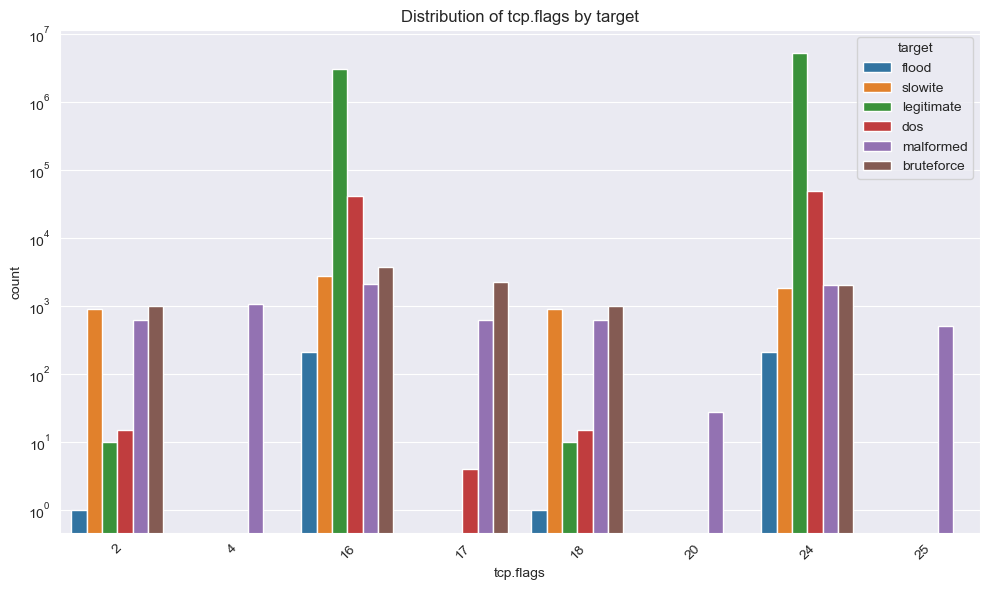

In [32]:
polars_plot_target_relationship(mqtt_df, "tcp.flags", log_scale=True)

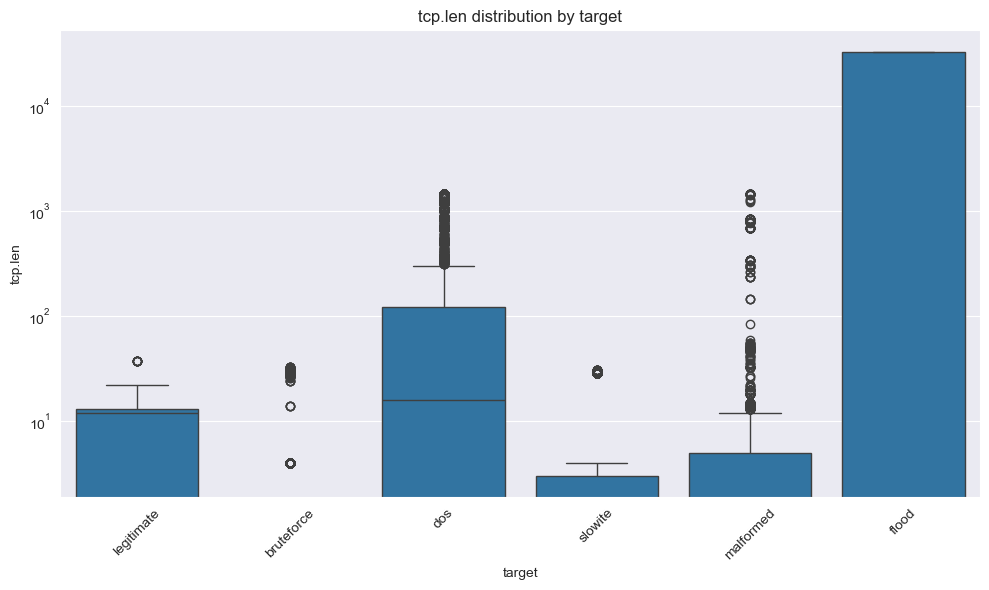

In [30]:
polars_plot_target_relationship(mqtt_df, "tcp.len", log_scale=True)

### Data Normalization